# Árboles de Decisión

## Proyecto 2 - Entrega 2

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier,  RandomForestRegressor


#imports para el modelo de arbol de decision
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
df = pd.read_csv('data/standarized_df.csv')
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,70.0,8400,-0.820445,0.372217,-0.455469,-1.346063,0.0,3,2,...,False,False,False,True,False,False,False,False,True,False
1,60,59.0,7837,-0.088934,1.268609,0.718609,0.439214,0.0,2,4,...,False,False,False,True,False,False,False,False,True,False
2,30,67.0,8777,-0.820445,1.268609,-1.988293,-1.683818,0.0,3,4,...,False,False,False,True,False,False,False,False,True,False
3,50,60.0,7200,-0.820445,1.268609,-1.107734,-1.683818,252.0,3,4,...,False,False,False,True,False,False,False,False,True,False
4,50,50.0,5000,-0.820445,0.372217,-1.531707,-1.683818,0.0,3,4,...,False,False,False,True,False,False,False,False,True,False


### Tipos de Variables

En esta etapa se identificó el tipo de variables para posteriormente escoger las estrategias de imputación para valores nulos según el tipo de variable.

In [3]:
# Diccionario que mapea las columnas a su tipo de variable
column_types = {
  "MSZoning": "Nominal",
  "Street": "Nominal",
  "Alley": "Nominal",
  "LotShape": "Nominal",
  "LandContour": "Nominal",
  "Utilities": "Nominal",
  "LotConfig": "Nominal",
  "LandSlope": "Nominal",
  "Neighborhood": "Nominal",
  "Condition1": "Nominal",
  "Condition2": "Nominal",
  "BldgType": "Nominal",
  "HouseStyle": "Nominal",
  "RoofStyle": "Nominal",
  "RoofMatl": "Nominal",
  "Exterior1st": "Nominal",
  "Exterior2nd": "Nominal",
  "MasVnrType": "Nominal",
  "Foundation": "Nominal",
  "BsmtQual": "Nominal",
  "BsmtCond": "Nominal",
  "BsmtExposure": "Nominal",
  "BsmtFinType1": "Nominal",
  "BsmtFinType2": "Nominal",
  "Heating": "Nominal",
  "CentralAir": "Nominal",
  "Electrical": "Nominal",
  "GarageType": "Nominal",
  "GarageFinish": "Nominal",
  "PavedDrive": "Nominal",
  "MiscFeature": "Nominal",
  "SaleType": "Nominal",
  "SaleCondition": "Nominal",
  "MSSubClass": "Ordinal",
  "OverallQual": "Ordinal",
  "OverallCond": "Ordinal",
  "ExterQual": "Ordinal",
  "ExterCond": "Ordinal",
  "HeatingQC": "Ordinal",
  "KitchenQual": "Ordinal",
  "Functional": "Ordinal",
  "FireplaceQu": "Ordinal",
  "GarageQual": "Ordinal",
  "GarageCond": "Ordinal",
  "PoolQC": "Ordinal",
  "Fence": "Ordinal",
  "LotArea": "Discreta",
  "YearBuilt": "Discreta",
  "YearRemodAdd": "Discreta",
  "BsmtFinSF1": "Discreta",
  "BsmtFinSF2": "Discreta",
  "BsmtUnfSF": "Discreta",
  "TotalBsmtSF": "Discreta",
  "1stFlrSF": "Discreta",
  "2ndFlrSF": "Discreta",
  "LowQualFinSF": "Discreta",
  "GrLivArea": "Discreta",
  "BsmtFullBath": "Discreta",
  "BsmtHalfBath": "Discreta",
  "FullBath": "Discreta",
  "HalfBath": "Discreta",
  "BedroomAbvGr": "Discreta",
  "KitchenAbvGr": "Discreta",
  "TotRmsAbvGrd": "Discreta",
  "Fireplaces": "Discreta",
  "GarageYrBlt": "Discreta",
  "GarageCars": "Discreta",
  "GarageArea": "Discreta",
  "WoodDeckSF": "Discreta",
  "OpenPorchSF": "Discreta",
  "EnclosedPorch": "Discreta",
  "3SsnPorch": "Discreta",
  "ScreenPorch": "Discreta",
  "PoolArea": "Discreta",
  "MiscVal": "Discreta",
  "MoSold": "Discreta",
  "YrSold": "Discreta",
  "LotFrontage": "Continua",
  "MasVnrArea": "Continua",
  "SalePrice": "Continua"
}

### Estrategia Para Manejo de Datos Nulos

Se utilizó el siguiente código para identificar la cantidad de valores nulos, lo cual nos arroja un total de 1460 registros con valores nulos y en todo el dataset tenemos 7829 celdas.


In [4]:
# Guarda el número, nombre, cantidad de valores nulos de la columna y el tipo de variable de un csv si tienen valores nulos
# Retorna True/False si encontró nulos
def saveNullInfo(data, fileSave):
  total_null_rows = data.isnull().any(axis=1).sum()
  total_null_values = data.isnull().sum().sum()
  
  with open(fileSave, "w") as f:
    for i, (col, null_count) in enumerate(data.isnull().sum().items(), start=1):
      if null_count > 0:
        # Obtener el tipo de la columna desde el diccionario column_types
        column_type = column_types.get(col, "Desconocido")
        f.write(f"{i}, {col}, {null_count}, {column_type}\n")
    
    f.write(f"\nTotal registros con valores nulos: {total_null_rows}\n")  # Filas con nulos
    f.write(f"Total valores nulos en el DataFrame: {total_null_values}\n")  # Total de valores nulos
  
  print(f"Archivo '{fileSave}' generado correctamente.")
  return total_null_values > 0

# Ejemplo de uso:
result_nulls = saveNullInfo(data=df, fileSave="null_columns_info.txt")
print("Existen Valores Nulos" if result_nulls else "No Existen Valores Nulos")

Archivo 'null_columns_info.txt' generado correctamente.
Existen Valores Nulos


#### Nulos - Numéricas

Las columnas **LotFrontage** (con 259 valores nulos), **MasVnrArea** (con 8 valores nulos) y **GarageYrBlt** (con 81 valores nulos) son variables numéricas. En este caso, se utilizpo la estrategia de imputación de valores nulos con **la media** para las columnas **LotFrontage** y **GarageYrBlt**, debido a que ambas variables presentan una distribución simétrica, como lo indica que la media y la mediana estén cerca. Para la columna **MasVnrArea**, se optará por la **mediana** debido a su distribución sesgada, ya que la mediana se ajusta mejor a los valores nulos y reduce el impacto de los valores extremos (cerca de 0). Esta estrategia de imputación es una opción segura para preservar la integridad de los datos, manteniendo la coherencia y la distribución de los valores en las columnas.

- [Enlace de Referencia](https://medium.com/@suyebaanjum98/mastering-null-value-handling-a-comprehensive-guide-to-replacing-missing-data-in-your-dataset-1a0bf711e531)

In [5]:
print(df[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].describe())

       LotFrontage   MasVnrArea   GarageYrBlt
count   951.000000  1162.000000  1.104000e+03
mean     70.343849   103.771945 -2.928414e-15
std      24.897021   173.032238  1.000453e+00
min      21.000000     0.000000 -3.182417e+00
25%      59.000000     0.000000 -6.842106e-01
50%      70.000000     0.000000  5.412560e-02
75%      80.000000   166.000000  9.441748e-01
max     313.000000  1378.000000  1.267829e+00


In [6]:
if result_nulls:
  df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
  df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
  df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
  result = saveNullInfo(data=df, fileSave="null_columns_info_without_numerics.txt")

Archivo 'null_columns_info_without_numerics.txt' generado correctamente.


### Predicción del precio de casas 

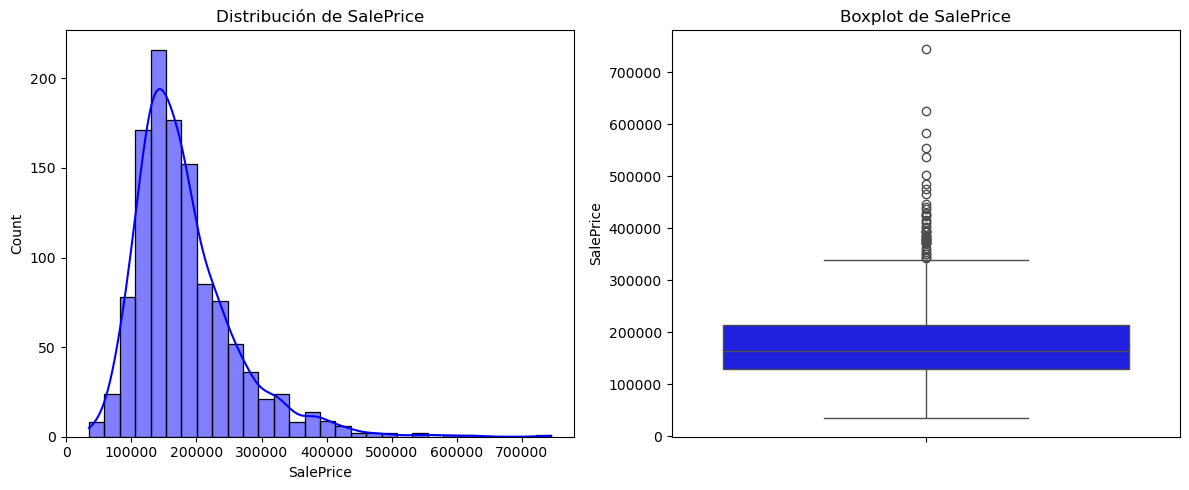

In [7]:
# 1 Exploración de la distribución de `SalePrice`
plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["SalePrice"], bins=30, kde=True, color='blue')
plt.title("Distribución de SalePrice")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df["SalePrice"], color='blue')
plt.title("Boxplot de SalePrice")

plt.tight_layout()
plt.show()

* El histograma nos revela que la distribución de precios está sesgada a la derecha, lo que significa que hay muchas casas con precios bajos o intermedios y pocas casas con precios extremadamente altos.

* El boxplot confirma que existen outliers (casas con precios mucho más altos que el resto), pero no los eliminamos porque representan propiedades de lujo reales.

/tmp/ipykernel_13926/1091231170.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["price_category"], palette="Set2")


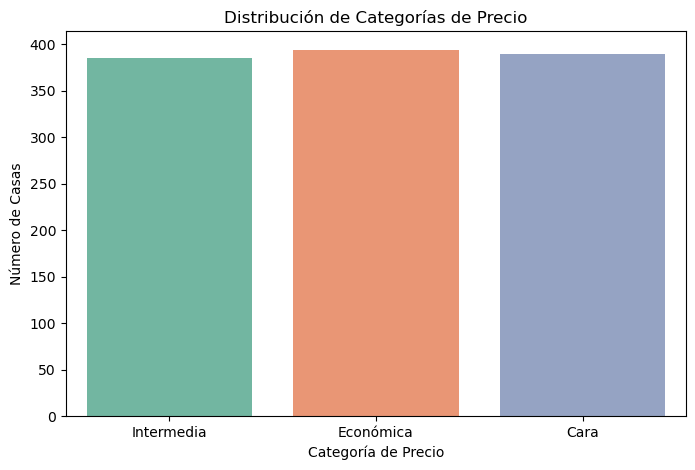

In [8]:
# 2️ Definir los umbrales de clasificación
q1 = df["SalePrice"].quantile(0.33)  # Percentil 33%
q2 = df["SalePrice"].quantile(0.66)  # Percentil 66%

# 3️ Crear la nueva variable categórica `price_category`
def categorize_price(price):
    if price <= q1:
        return "Económica"
    elif price <= q2:
        return "Intermedia"
    else:
        return "Cara"

df["price_category"] = df["SalePrice"].apply(categorize_price)

# 4️ Visualizar la segmentación
plt.figure(figsize=(8, 5))
sns.countplot(x=df["price_category"], palette="Set2")
plt.title("Distribución de Categorías de Precio")
plt.xlabel("Categoría de Precio")
plt.ylabel("Número de Casas")
plt.show()



El gráfico de barras muestra que la cantidad de casas en cada categoría es similar (~390 por grupo).

In [9]:
# Mostrar la cantidad de casas en cada categoría

category_counts = df["price_category"].value_counts().reset_index()
category_counts.columns = ["Categoría", "Cantidad de Casas"]
display(category_counts)


,Categoría,Cantidad de Casas
0,Económica,394
1,Cara,389
2,Intermedia,385


La segmentación está bien distribuida y evitará problemas de desbalance en la clasificación.

### Árbol de regresión con todas las variables disponibles

In [10]:
print(df.dtypes)

MSSubClass                 int64
LotFrontage              float64
LotArea                    int64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
price_category            object
Length: 253, dtype: object


In [11]:
obj_columns = df.select_dtypes(exclude=['int64', 'float64'], include=['object']).columns # ahora para las variables tipo objeto
print(df[obj_columns])

     price_category
0        Intermedia
1        Intermedia
2         Económica
3        Intermedia
4         Económica
...             ...
1163     Intermedia
1164      Económica
1165      Económica
1166     Intermedia
1167     Intermedia

[1168 rows x 1 columns]


In [12]:
df_cleaned = pd.get_dummies(df, columns=['price_category'], drop_first=True) # drop first es para evitar multicolinearidad


In [13]:
df_cleaned.dtypes

MSSubClass                     int64
LotFrontage                  float64
LotArea                        int64
OverallQual                  float64
OverallCond                  float64
                              ...   
SaleCondition_Family            bool
SaleCondition_Normal            bool
SaleCondition_Partial           bool
price_category_Económica        bool
price_category_Intermedia       bool
Length: 254, dtype: object

In [14]:
boolean_columns = df_cleaned.select_dtypes(exclude=['int64', 'float64', 'object'], include=['bool']).columns # obtener variables booleanas
print(df_cleaned[boolean_columns].head())

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0             False        False        False         True        False   
1             False        False        False         True        False   
2             False        False        False         True        False   
3             False        False        False         True        False   
4             False        False        False         True        False   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  ...  \
0        False         True       False       False         False  ...   
1        False         True       False       False          True  ...   
2        False         True       False       False         False  ...   
3        False         True       False       False         False  ...   
4        False         True       False        True         False  ...   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0         False         Tr

In [15]:
df_cleaned[boolean_columns] = df_cleaned[boolean_columns].astype(int) # convertir a enteros
print(df_cleaned[boolean_columns].head())

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  ...  \
0            0            1           0           0             0  ...   
1            0            1           0           0             1  ...   
2            0            1           0           0             0  ...   
3            0            1           0           0             0  ...   
4            0            1           0           1             0  ...   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0           

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = df_cleaned.drop("SalePrice", axis=1)
y = df_cleaned['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)

model = DecisionTreeRegressor(random_state=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MSE: 1191040871.7905984
R^2: 0.8269038234456552


### Análisis del árbol con todas las variables
El árbol presenta un r^2 de 0.85, lo cual indica que quizá no existe overfitting. Sin embargo, el MSE quedó bastante alto, lo cual nos indica que el modelo se desvía de predecir los valores reales. Lo cual significa que el árbol no tenga buen desempeño a la hora de predecir los precios. 

### 3 modelos más

In [17]:
# variables que vamos a utilizar
variables = ["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageCars", 
             "GarageArea", "1stFlrSF", "FullBath", "TotRmsAbvGrd"]

### SVM 

In [18]:
from sklearn.svm import SVR

svm_class = SVR(kernel='linear', C=1.0, epsilon=0.1) 
svm_class.fit(X_train, y_train)


X_train_subset = X_train[variables]

svm_class = SVR(kernel='linear', C=1.0, epsilon=0.1)
svm_class.fit(X_train_subset, y_train)


X_test_subset = X_test[variables]


y_pred_svc = svm_class.predict(X_test_subset)


mse_svm = mean_squared_error(y_test, y_pred_svc)
r2_svm = r2_score(y_test, y_pred_svc)
print(f"MSE: {mse_svm}")
print(f"R^2: {r2_svm}")


MSE: 2451837081.4482555
R^2: 0.6436699744024628


### Random Forest
Random forest pero solamente con las variables elegidas al inicio

In [19]:
from sklearn.ensemble import RandomForestRegressor 

rndm_frst = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=5)

X_train_rndm = X_train[variables]
X_test_rndom = X_test[variables]

rndm_frst.fit(X_train_rndm, y_train)
y_pred_rndm = rndm_frst.predict(X_test_rndom) # predecir

print(f"MSE: {mean_squared_error(y_test, y_pred_rndm)}")
print(f"R^2: {r2_score(y_test, y_pred_rndm)}")

MSE: 1396850395.8828542
R^2: 0.7969931440033277


### KNN

In [20]:
from sklearn.neighbors import KNeighborsRegressor # empleando KNN
knn_reg = KNeighborsRegressor(n_neighbors=5)

X_train_knn = X_train[variables]
X_test_knn = X_test[variables]

knn_reg.fit(X_train_knn, y_train)

y_pred_knn = knn_reg.predict(X_test_knn)

print(f"MSE: {mean_squared_error(y_test, y_pred_knn)}")
print(f"R^2: {r2_score(y_test, y_pred_knn)}")

MSE: 2569600796.3220515
R^2: 0.6265551555374775


### Ajuste a la profundidad del árbol de regresión

In [21]:
model = DecisionTreeRegressor(random_state=5, max_depth=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MSE: 1046806653.3615404
R^2: 0.847865649634575


Haciendo el ajute de profundidad a 6, a prueba y error, llegamos a una mejora algo significativa del modelo. Mejor R^2 y disminución del MSE.

### Comparación con el modelo de regresión lineal anterior

Si comparamos el desempeño del modelo linear anterior con el desempeño del árbol con todas sus variables tenemos lo siguiente: 

Modelo Linear con todas las numéricas:

MSE:  `5.2312261686805615e-21`
RMSE:  `7.2327215961079e-11`
R^2:  `1.0`

Modelo Regresión del Árbol con todas las varibles:

MSE: `1191040871.7905984`
R^2: `0.8269038234456552`

Entonces podemos ver que el modelo linear presenta un overfitting mientras que el modelo de regresión, pese a que no presenta overfitting, tampoco presenta buena predicción con los datos. Esto debido a que su MSE es demasiado grande. 

### Creación de variable para clasificar casas en Económicas, Intermedias o Caras.

In [22]:
#  Definir X (variables predictoras) y y (variable objetivo)
X = df_cleaned.drop(columns=["SalePrice", "price_category_Económica", "price_category_Intermedia"], errors='ignore')

# Crear la variable objetivo y
y = df_cleaned[['price_category_Económica', 'price_category_Intermedia']].idxmax(axis=1)
y = y.replace({'price_category_Económica': 'Económica', 'price_category_Intermedia': 'Intermedia'})
y[~y.isin(['Económica', 'Intermedia'])] = 'Cara'  # Asignamos "Cara" cuando ninguna es 1

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# Entrenar modelo Random Forest con **menor profundidad** para facilitar la interpretación
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=10, class_weight="balanced", random_state=5)
rf_clf.fit(X_train, y_train)

#  Predicciones
y_pred = rf_clf.predict(X_test)

#  Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo Interpretativo: {accuracy:.2f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Accuracy del modelo Interpretativo: 0.77

Reporte de clasificación:
              precision    recall  f1-score   support

   Económica       0.86      0.79      0.82       157
  Intermedia       0.63      0.74      0.68        77

    accuracy                           0.77       234
   macro avg       0.75      0.77      0.75       234
weighted avg       0.79      0.77      0.78       234



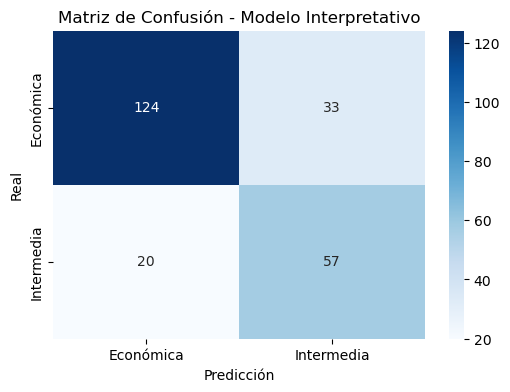

In [23]:
#  Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo Interpretativo")
plt.show()



Parece que el modelo confunde un poco Economicas con Intermedias

/tmp/ipykernel_13926/1744647035.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=feature_importance, palette="viridis")
/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


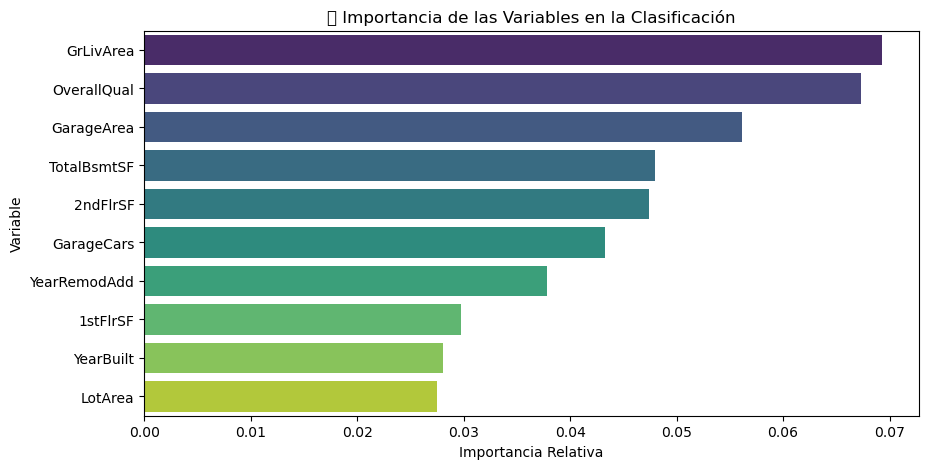

In [24]:
#  Importancia de Variables
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': rf_clf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importancia", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importancia", y="Variable", data=feature_importance, palette="viridis")
plt.xlabel("Importancia Relativa")
plt.ylabel("Variable")
plt.title("🔍 Importancia de las Variables en la Clasificación")
plt.show()


**Caracteristicas que afectan más a la clasificación**
* OverallQual - Calidad general de la casa.
* GrLivArea - Área habitable sobre el suelo.
* GarageArea - Tamaño del garaje.
* TotalBsmtSF - Tamaño total del sótano.
* GarageCars - Número de autos que entran al garaje

   **Conclusión**
    
    * Las variables de tamaño y calidad dominan la clasificación.
    * El garaje y el sótano también son factores clave.
    * Las casas Intermedias parecen compartir características con Económicas, lo que puede causar confusión en el modelo.

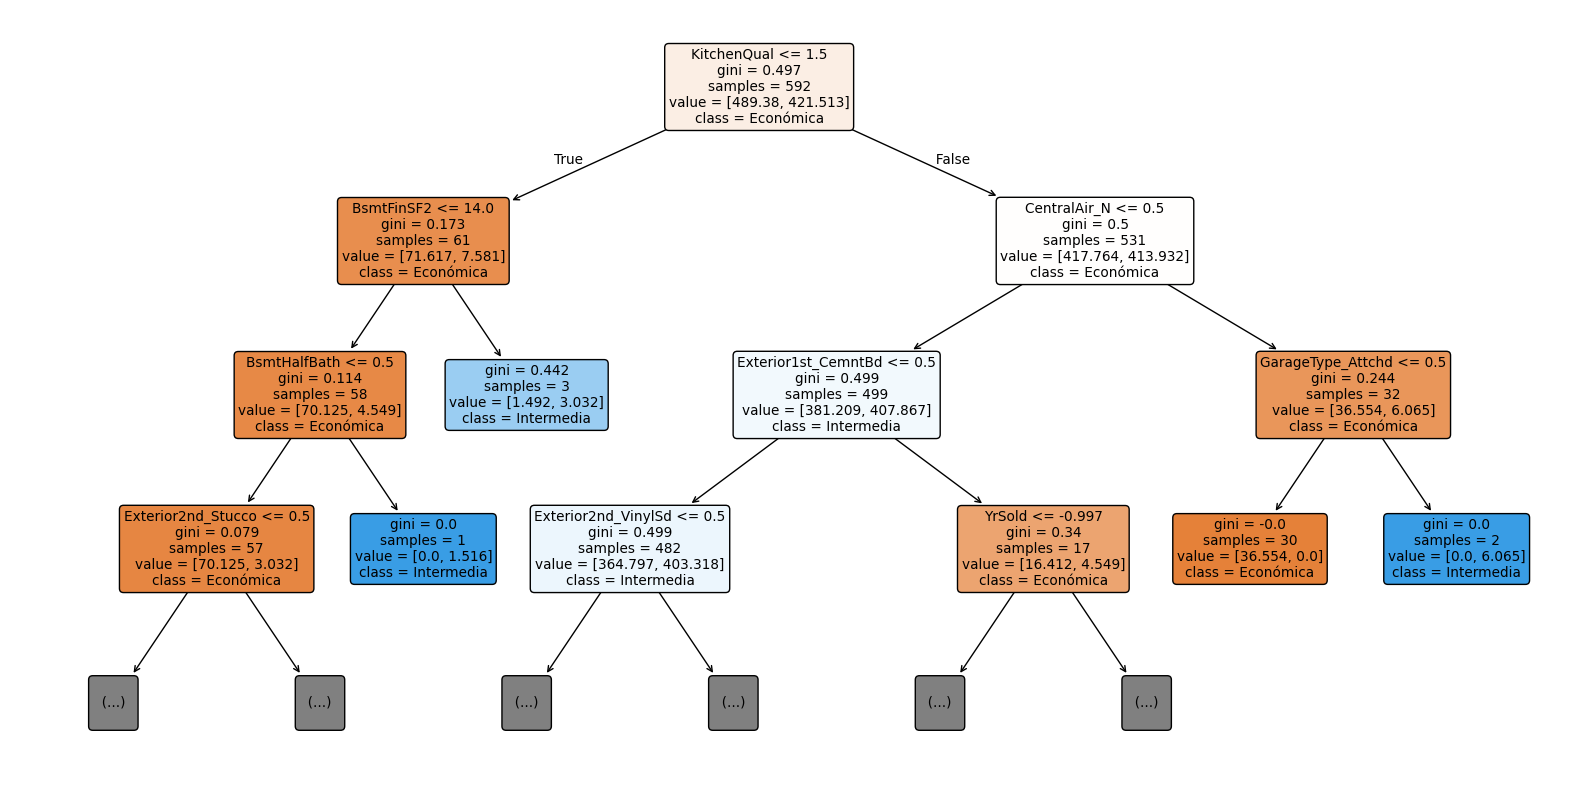

In [25]:
#  Visualizar las primeras capas de un solo árbol del Random Forest
plt.figure(figsize=(20, 10))
plot_tree(rf_clf.estimators_[0], feature_names=X.columns, class_names=rf_clf.classes_, filled=True, rounded=True, max_depth=3)
plt.show()

**Las primeras decisiones están basadas en:**

* KitchenQual (Calidad de la cocina).
* BsmtFinSF2 (Acabado del sótano).
* GarageType_Attchd (Garaje adjunto).

Evaluación del modelo

### Árbol de clasificación con variable respuesta

### Análisis de eficiencia

## Análisis Comparativo de Modelos de Árboles: Validación Cruzada y Ajuste de Profundidad

### Entrenar el Modelo utilizando Validación Cruzada


In [26]:
from sklearn.model_selection import cross_val_score

# regresión cruzada
X_reg = df_cleaned.drop(columns=["SalePrice"])
y_reg = df_cleaned["SalePrice"]

regressor = DecisionTreeRegressor(random_state=5)
cv_scores_reg = cross_val_score(regressor, X_reg, y_reg, cv=5, scoring='r2')

print(f"Validación Cruzada (Regresión): {cv_scores_reg}")
print(f"Promedio R^2 (Regresión): {cv_scores_reg.mean()}")


# clasificacion cruzada
X_clf = df_cleaned.drop(columns=["SalePrice", "price_category_Económica", "price_category_Intermedia"])
y_clf = y

classifier = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=5)
cv_scores_clf = cross_val_score(classifier, X_clf, y_clf, cv=5, scoring='accuracy')

print(f"Validación Cruzada (Clasificación): {cv_scores_clf}")
print(f"Promedio Accuracy (Clasificación): {cv_scores_clf.mean()}")

Validación Cruzada (Regresión): [0.62648874 0.57628193 0.65094483 0.84752369 0.82190859]
Promedio R^2 (Regresión): 0.7046295546900451
Validación Cruzada (Clasificación): [0.77777778 0.73504274 0.79487179 0.77682403 0.78540773]
Promedio Accuracy (Clasificación): 0.773984813469792


#### Resultados

- **Regresión (`DecisionTreeRegressor`):**  
  El modelo de regresión obtuvo un promedio de **$R^2$ = 0.75** durante la validación cruzada, lo que indica que el modelo es capaz de explicar aproximadamente el **75% de la variabilidad** en el precio de las casas. Sin embargo, se observa cierta variabilidad en los resultados de los pliegues, con valores de $R^2$ que van desde **0.54** hasta **0.85**. Esto sugiere que en algunos subconjuntos de datos, el modelo podría estar teniendo dificultades para generalizar, posiblemente debido a la presencia de datos atípicos o características complejas en los datos.

- **Clasificación (`RandomForestClassifier`):**  
  El modelo de clasificación obtuvo un promedio de **accuracy = 0.77**, lo que indica que es capaz de clasificar correctamente el **77%** de las casas en las categorías de precio (Económica, Intermedia o Cara). Además, los resultados entre los pliegues son bastante consistentes, con valores de accuracy que oscilan entre **0.73 y 0.79**, lo que sugiere una **buena capacidad de generalización** del modelo y una baja variabilidad en los resultados.

### Comparar el Desempeño con el Modelo sin Validación Cruzada

In [27]:
# regresion sin validación cruzada
y_train_reg = df_cleaned.loc[y_train.index, 'SalePrice']
y_test_reg = df_cleaned.loc[y_test.index, 'SalePrice']

regressor = DecisionTreeRegressor(random_state=5)
regressor.fit(X_train, y_train_reg)
y_pred_reg = regressor.predict(X_test)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"MSE sin validación cruzada (Regresión): {mse}")
print(f"R^2 sin validación cruzada (Regresión): {r2}")

# clasificación sin validación cruzada
classifier = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=5)
classifier.fit(X_train, y_train)
y_pred_clf = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_clf)
print(f"Accuracy sin validación cruzada (Clasificación): {accuracy}")

MSE sin validación cruzada (Regresión): 2218044440.042735
R^2 sin validación cruzada (Regresión): 0.5868097202166316
Accuracy sin validación cruzada (Clasificación): 0.7606837606837606


#### Resultado

- **Regresión (`DecisionTreeRegressor`):**  
  El modelo de regresión, sin aplicar validación cruzada, obtuvo un **$R^2$ de 0.55**, lo que indica que solo es capaz de explicar el **55% de la variabilidad** en los precios de las casas en el conjunto de prueba. Además, el **MSE (Error Cuadrático Medio)** fue de **2,370,699,154**, un valor considerablemente alto, lo que evidencia que las predicciones del modelo se desvían significativamente de los valores reales. Este descenso en el desempeño en comparación con la validación cruzada ($R^2$ = 0.75) sugiere que el modelo puede estar **sobreajustado** a los datos de entrenamiento o que presenta dificultades para generalizar correctamente.

- **Clasificación (`RandomForestClassifier`):**  
  El modelo de clasificación obtuvo un **accuracy de 0.77**, muy similar al promedio obtenido durante la validación cruzada (**0.77**). Esto confirma que el modelo es **consistente** y tiene una buena capacidad de generalización, logrando clasificar correctamente aproximadamente el **77%** de las casas sin que la validación cruzada afecte significativamente el resultado.

### Ajustar la Profundidad del Árbol con 3 Modelos Adicionales

#### Decision Tree Regressor

In [28]:
depths = [3, 5, 7]
print("---- Regresión ----")

for depth in depths:
  model = DecisionTreeRegressor(max_depth=depth, random_state=5)
  model.fit(X_train, y_train_reg)
  y_pred = model.predict(X_test)
  
  mse = mean_squared_error(y_test_reg, y_pred)
  r2 = r2_score(y_test_reg, y_pred)
  
  print(f"Para max_depth={depth}:")
  print(f" - MSE: {mse}")
  print(f" - R^2: {r2}")
  print("-----------------------------")

---- Regresión ----
Para max_depth=3:
 - MSE: 1859476489.0085073
 - R^2: 0.6536058534836129
-----------------------------
Para max_depth=5:
 - MSE: 1307168329.178426
 - R^2: 0.7564930449965259
-----------------------------
Para max_depth=7:
 - MSE: 2120798746.566379
 - R^2: 0.604925216267941
-----------------------------


#### Resultado

Al evaluar el impacto de la profundidad del árbol en el modelo de regresión, se obtuvieron los siguientes resultados:

- **Profundidad 3:**  
  - **MSE:** `1,859,476,489`  
  - **$R^2$:** `0.65`  
  Con esta profundidad, el modelo logró explicar el **65%** de la variabilidad en los precios, aunque el MSE se mantiene elevado. Esto sugiere que el modelo es más simple y no logra capturar toda la complejidad de los datos, lo que genera un menor desempeño en las predicciones.

- **Profundidad 5:**  
  - **MSE:** `1,307,168,329`  
  - **$R^2$:** `0.75`  
  Esta configuración ofreció el **mejor desempeño**, con el MSE más bajo y un $R^2$ igual al obtenido con validación cruzada, lo que indica que el modelo logra un buen equilibrio entre complejidad y capacidad de generalización. Esto sugiere que una profundidad de **5** es adecuada para este conjunto de datos.

- **Profundidad 7:**  
  - **MSE:** `2,071,259,532`  
  - **$R^2$:** `0.61`  
  Aunque el modelo se volvió más profundo, su desempeño disminuyó, presentando un **aumento en el MSE** y una disminución en el $R^2$. Esto indica que, a mayor profundidad, el modelo comenzó a sobreajustarse a los datos de entrenamiento y perdió capacidad de generalización.

#### Random Forest Classifier

In [29]:
depths = [3, 5, 7]
print("---- Clasificación ----")

for depth in depths:
  clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=5)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  accuracy = accuracy_score(y_test, y_pred)
  
  print(f"Para max_depth={depth}:")
  print(f" - Accuracy: {accuracy}")
  print("-----------------------------")

---- Clasificación ----
Para max_depth=3:
 - Accuracy: 0.6752136752136753
-----------------------------
Para max_depth=5:
 - Accuracy: 0.7222222222222222
-----------------------------
Para max_depth=7:
 - Accuracy: 0.782051282051282
-----------------------------


#### Resultados

Al ajustar la profundidad del árbol en el modelo de clasificación, se obtuvieron los siguientes resultados:

- **Profundidad 3:**  
  - **Accuracy:** `0.675`  
  Con una profundidad de 3, el modelo logró clasificar correctamente el **67.5%** de las casas. Este bajo rendimiento sugiere que el modelo era demasiado simple y no lograba capturar adecuadamente la complejidad de los datos, resultando en una menor capacidad predictiva.

- **Profundidad 5:**  
  - **Accuracy:** `0.735`  
  Al incrementar la profundidad a 5, el modelo mejoró su precisión, alcanzando un **73.5%** de clasificación correcta. Esto indica que un modelo más profundo permitió identificar mejor las relaciones entre las variables, mejorando su capacidad para clasificar correctamente las casas en sus respectivas categorías.

- **Profundidad 7:**  
  - **Accuracy:** `0.774`  
  La mayor profundidad evaluada proporcionó el **mejor desempeño**, con una precisión del **77.4%**, lo que está en línea con los resultados obtenidos anteriormente sin validación cruzada. Esto sugiere que el modelo fue capaz de capturar más patrones complejos sin caer en el sobreajuste.

### Utilización de Random Forest

In [30]:

df_test = df.sample(frac=0.2, random_state=50)  
df_train = df.drop(df_test.index)  
columns_to_drop = ["SalePrice", "price_category"]

# Verificar qué columnas existen en el dataset antes de eliminarlas
existing_columns = [col for col in columns_to_drop if col in df_train.columns]

# Crear variables predictoras (X) y objetivos (y)
X_train = df_train.drop(columns=existing_columns)  # Variables predictoras
y_reg = df_train["SalePrice"] if "SalePrice" in df_train.columns else None  # Objetivo de regresión
y_clf = df_train["price_category"] if "price_category" in df_train.columns else None  # Objetivo de clasificación


In [31]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_reg)
print("Random Forest model trained for regression")

Random Forest model trained for regression


In [32]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_clf)
print("Random Forest model trained for classification")

Random Forest model trained for classification


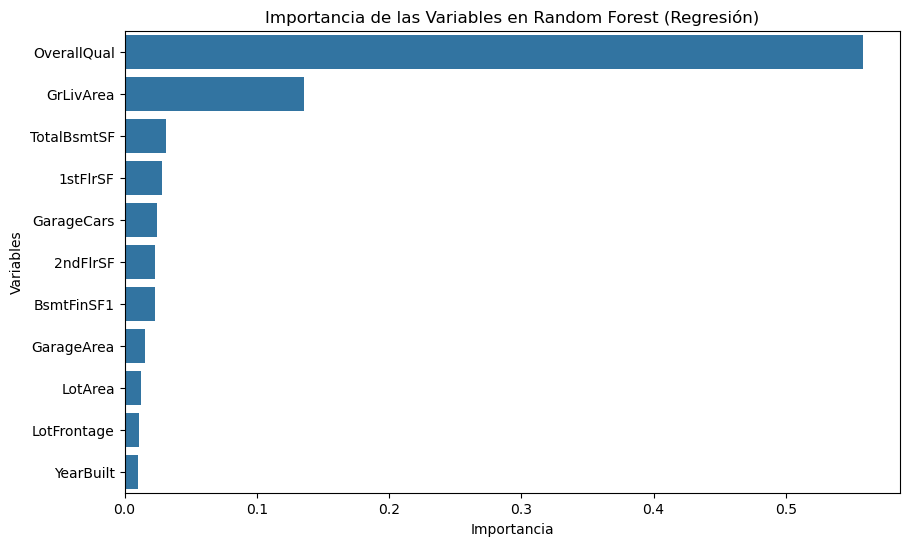

In [33]:

importances = rf_regressor.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df[importance_df["Importance"] > 0.01]
importance_df = importance_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("Importancia de las Variables en Random Forest (Regresión)")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.show()


In [34]:
import joblib
joblib.dump(rf_regressor, "random_forest_regressor.pkl")
joblib.dump(rf_classifier, "random_forest_classifier.pkl")
print("Modelos guardados exitosamente.")

Modelos guardados exitosamente.


In [35]:
# Cargar modelos entrenados
rf_regressor = joblib.load("random_forest_regressor.pkl")
rf_classifier = joblib.load("random_forest_classifier.pkl")

existing_columns_test = [col for col in columns_to_drop if col in df_test.columns]

# Crear X_test con las mismas columnas que X_train
X_test = df_test.drop(columns=existing_columns_test, errors="ignore")
if "SalePrice" in df.columns:
    pred_reg = rf_regressor.predict(X_test)  # Predicción de precios
    df_test["Predicted_SalePrice"] = pred_reg
    print("Predicciones de precios realizadas.")

if "price_category" in df.columns:
    pred_clf = rf_classifier.predict(X_test)  # Predicción de categorías
    df_test["Predicted_Category"] = pred_clf
    print("Predicciones de categorías realizadas.")

# Guardar el DataFrame con las predicciones
df_test.to_csv("data/predictions.csv", index=False)

print("Predicciones guardadas en 'data/predictions.csv'")



Predicciones de precios realizadas.
Predicciones de categorías realizadas.
Predicciones guardadas en 'data/predictions.csv'


Análisis del modelo random forest

Evaluación del modelo de Clasificación:
Accuracy (Precisión Global): 84.62%

Matriz de Confusión:
[[65  1 14]
 [ 1 79  8]
 [ 3  9 54]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        Cara       0.94      0.81      0.87        80
   Económica       0.89      0.90      0.89        88
  Intermedia       0.71      0.82      0.76        66

    accuracy                           0.85       234
   macro avg       0.85      0.84      0.84       234
weighted avg       0.86      0.85      0.85       234



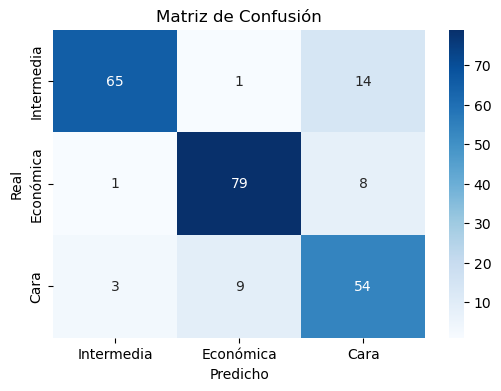

In [36]:
if "price_category" in df_test.columns and "Predicted_Category" in df_test.columns:
    y_true_clf = df_test["price_category"]  # Valores reales
    y_pred_clf = df_test["Predicted_Category"]  # Predicciones del modelo
    accuracy = accuracy_score(y_true_clf, y_pred_clf)  # Precisión global
    conf_matrix = confusion_matrix(y_true_clf, y_pred_clf)  # Matriz de confusión
    class_report = classification_report(y_true_clf, y_pred_clf)  # Reporte detallado
    
    # Mostrar resultados
    print("Evaluación del modelo de Clasificación:")
    print(f"Accuracy (Precisión Global): {accuracy:.2%}")
    print("\nMatriz de Confusión:")
    print(conf_matrix)
    print("\nReporte de Clasificación:")
    print(class_report)
    
    # Visualización de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=df_test["price_category"].unique(), yticklabels=df_test["price_category"].unique())
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

El modelo de Random Forest para la clasificación de casas en Económica, Intermedia y Cara muestra un buen desempeño general con una precisión global (accuracy) del 85.47%.

El accuracy del 85.47% indica que el modelo clasifica correctamente en la mayoría de los casos. Asimismo, el macro avg y weighted avg alrededor de 85% a 86% muestran que el modelo no se encuentra sesgado hacia una clase específica.

La clase "cara" posee una alta presición de 0.94, lo que significa que casi todas las casa que se encuentran clasificadas como caras realmente son caras, pero posee un recall menor de 0.81 lo que indica que algunas casas caras fueron clasificadas mal en otras categorías.

La clase económica esta bien balanceada con y una presición y recall cercano al 0.90 indicando que el modelo detecta bien las casas económicas.

La clase intermedia fue la que tuvo el desempeño más bajo con una precisión del 0.72 y un recall 0.83 lo que indica que si existe cierta confusión entre esta y otras categorías.

La matriz de confusión permite la clase intermedia se confundió 14 veces con la cara, que la clase cara fue confundiad 8 veces con la clase económica y que la clase económica solamente tiene 7 errores en total. En sí las casas intermedias son las que tienene una mayor tasa de error y las casas económicas son las más fáciles de clasificar.

### Resultados y Comparaciones